# **Bar-Code Detection and Decoding** ║▌║█║▌│║▌║▌█
Student Name: Rasha Abu Rkab
\
Student ID: 220210069



#### The primary goal of this code is to take an **input image**, process it to enhance the visibility of barcodes, and then extract and decode any barcodes found. This is achieved through a combination of:

* ##### Image pre-processing techniques (grayscale conversion, Gradiant, blurring, thresholding, and morphological operations).

* ##### Contour detection to find the barcode.

* ##### Barcode decoding and result display.

# **Code implementation:**

### **1. Import Libraries:**

In [ ]:
# requirements
# pip install numpy
# pip install opencv-python
# pip install matplotlib

!pip install pyzbar
!apt install libzbar0


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libzbar0 is already the newest version (0.23.92-4build2).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pyzbar.pyzbar import decode
import glob

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# access to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **2. Read and Resize the Image:**

In [ ]:
def read_image(image_path):
    """Reads an image from a given path."""
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Error: Unable to load image at {image_path}.")
    return image

def resize_image(image, width=1000):
    """Resize the image to a specific width while maintaining the aspect ratio."""
    aspect_ratio = float(image.shape[1]) / float(image.shape[0])
    new_height = int(width / aspect_ratio)
    resized_image = cv2.resize(image, (width, new_height))
    return resized_image

### **3. Processing the Image:**

In [ ]:
def process_image(image):
    """Processes the image to detect rectangular contours."""

    # Convert image to grayscale (if not already grayscale)
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Calculate gradient using Sobel operators in vertical direction
    sobel_y = np.array([[-1, 0,  1],
                        [-2, 0,  2],
                        [-1, 0,  1]])

    gradient_y = cv2.filter2D(gray, -1, sobel_y)

    # Apply median blur for noise reduction
    blurred = cv2.GaussianBlur(gradient_y, (7,7), 3.5)

    # Apply adaptive thresholding
    adaptive_thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 3)
    adaptive_thresh = cv2.medianBlur(adaptive_thresh, 5)



    # Morphological operations to close small gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,3))
    closed = cv2.erode(adaptive_thresh, kernel, iterations=1)
    closed = cv2.morphologyEx(closed, cv2.MORPH_CLOSE, kernel)


    return gradient_y, blurred, adaptive_thresh, closed

### **4. Contour Detection and Barcode Decoding:**

In [ ]:
def find_largest_contour(image, closed):
    """Finds and draws the largest rectangular contour in the image."""
    contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        raise ValueError("No contours found in the image.")

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(largest_contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # Draw the contour on the original image
    result_image = image.copy()
    cv2.drawContours(result_image, [box], -1, (0, 165, 255), 2)
    return result_image, box

def decode_barcode(result_image):
    """Decodes barcodes in the image using pyzbar."""
    barcodes = decode(result_image)
    decoded_info = []

    if not barcodes:
        print("No barcodes found.")
    else:
        for barcode in barcodes:
            barcode_data = barcode.data.decode("utf-8")
            decoded_info.append(barcode_data)
            print(f"Decoded Barcode: {barcode_data}")

            rect = barcode.rect
            x, y, w, h = rect[0], rect[1], rect[2], rect[3]

            cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 8)

            text = barcode_data
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 2.2
            font_thickness = 5
            text_color = (255, 0, 0)
            background_color = (255, 255, 255)

            (text_width, text_height), _ = cv2.getTextSize(text, font, font_scale, font_thickness)

            text_x = x + 2
            text_y = y - 5

            cv2.rectangle(result_image, (text_x, text_y - text_height - 10), (text_x + text_width, text_y + 10), background_color, -1)

            cv2.putText(result_image, text, (text_x, text_y), font, font_scale, text_color, font_thickness)

    return decoded_info, result_image

### **5. Displaying Results:**

In [ ]:
def show_images(images, titles):
    """Helper function to display multiple images."""
    num_images = len(images)
    plt.figure(figsize=(16, 12))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.title(titles[i])
        plt.imshow(images[i], cmap='gray' if len(images[i].shape) == 2 else None)
        plt.axis('off')
    plt.show()

def analyze_image(image_path):
    """Full pipeline to analyze an image and display intermediate results."""
    try:
        # Step 1: Read the image
        image = read_image(image_path)

        # Step 2: Resize the image for better barcode detection
        resized_image = resize_image(image)

        # Step 3: Convert the resized image to RGB for display purposes
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

        # Step 4: Process the image (gradient, blur, threshold, morphology)
        gradient, blurred, thresh, closed = process_image(resized_image)

        # Step 5: Detect the largest contour in the processed image
        result_image, _ = find_largest_contour(resized_image, closed)
        result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

        # Step 6: Decode barcodes from the final processed image (result_image)
        decoded_info, result_image_with_text = decode_barcode(result_image)

        # Step 7: Print the decoded barcode information
        if decoded_info:
            print(f"Decoded Barcodes: {decoded_info}")
        else:
            print("No barcodes detected.")

        # Step 8: Display the original and processed images
        show_images(
            [resized_image, gradient, blurred, thresh, closed, result_image_with_text],
            ["Original Image", "Gradient Image", "Blurred", "Threshold", "Morphology", "Final Result"]
        )
    except Exception as e:
        print(f"An error occurred: {e}")

# **Results:**
This Link to [The image Folder](https://drive.google.com/drive/folders/1WkvqM8MnDMtXQNJ26j3SKvO7F8pBOwDG?usp=sharing)

Analyzing Image
Decoded Barcode: 0123456789128
Decoded Barcodes: ['0123456789128']


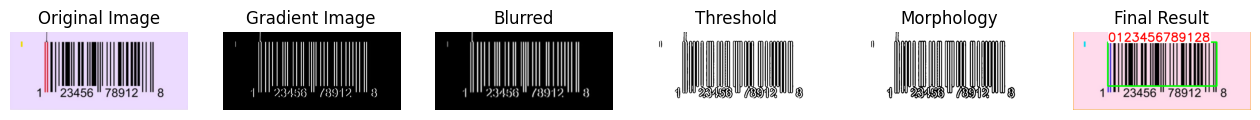

Analyzing Image
Decoded Barcode: 9556296000206
Decoded Barcodes: ['9556296000206']


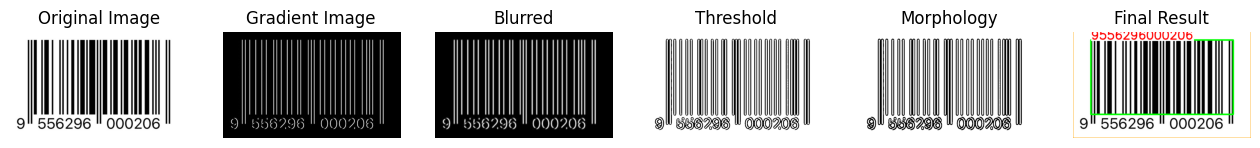

Analyzing Image
Decoded Barcode: 0051500241639
Decoded Barcodes: ['0051500241639']


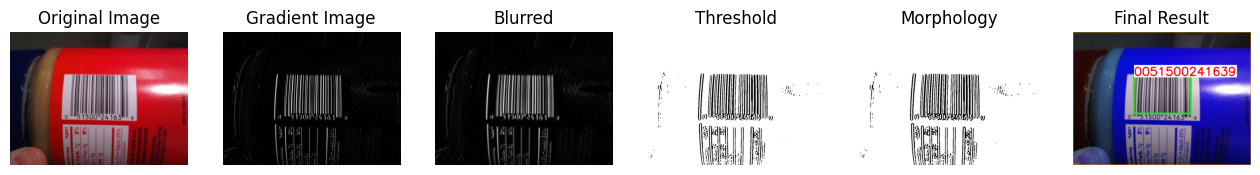

Analyzing Image
Decoded Barcode: 95200002
Decoded Barcodes: ['95200002']


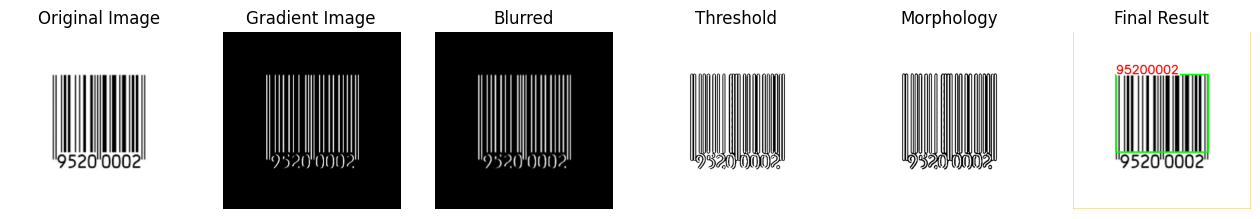

Analyzing Image
Decoded Barcode: 9783827313591
Decoded Barcodes: ['9783827313591']


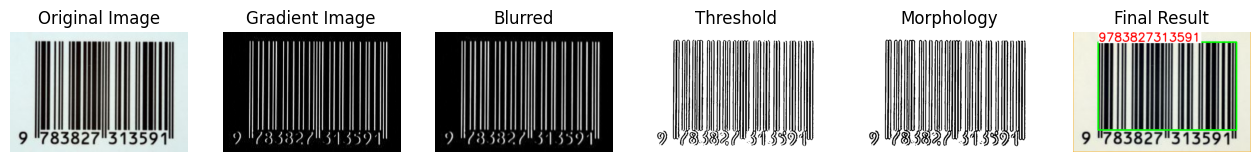

Analyzing Image
Decoded Barcode: 0010900005210
Decoded Barcodes: ['0010900005210']


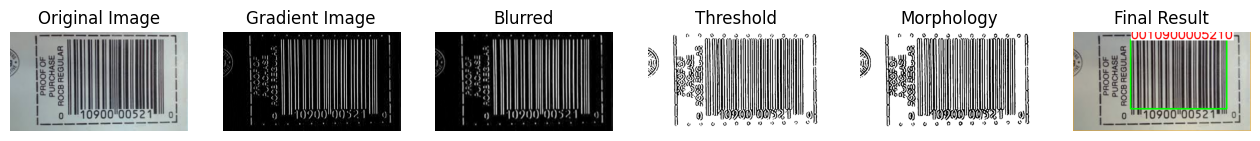

Analyzing Image
Decoded Barcode: 8907816315026
Decoded Barcodes: ['8907816315026']


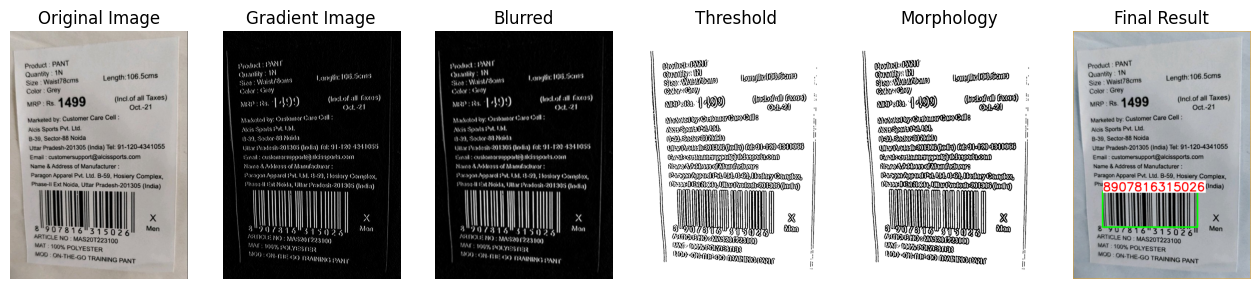

Analyzing Image
Decoded Barcode: 4049661481656
Decoded Barcodes: ['4049661481656']


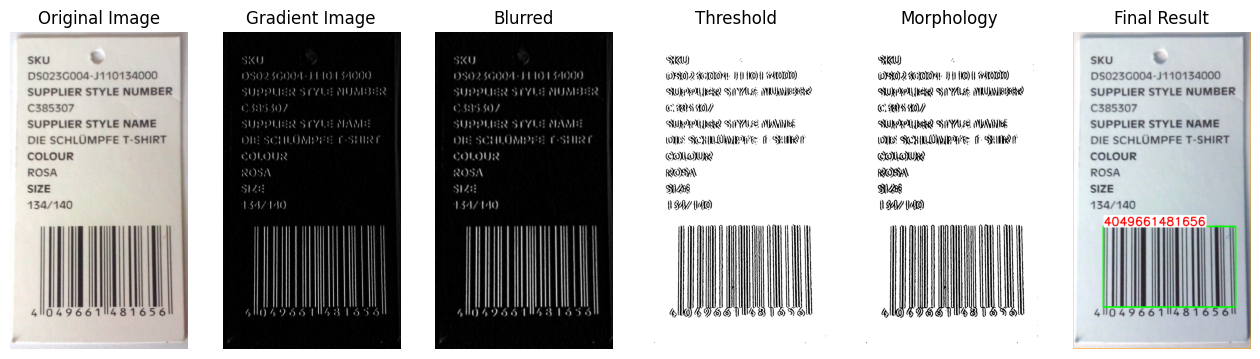

Analyzing Image
Decoded Barcode: 0725840025685
Decoded Barcodes: ['0725840025685']


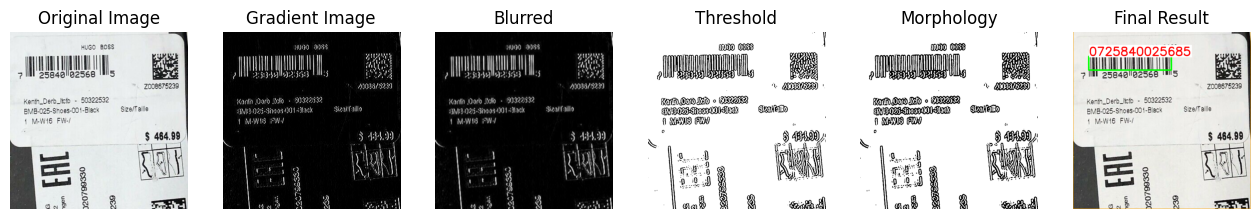

Analyzing Image
Decoded Barcode: 0604552150666
Decoded Barcodes: ['0604552150666']


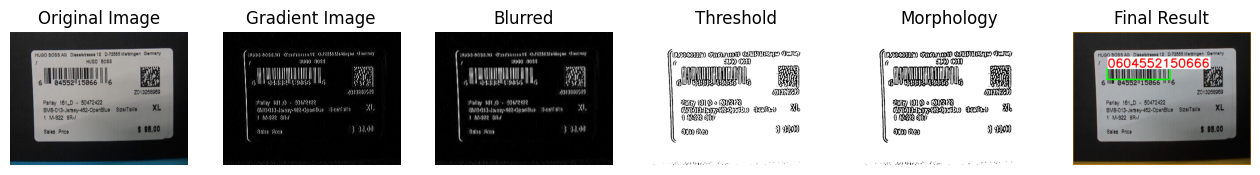

Analyzing Image
Decoded Barcode: 0886353906875
Decoded Barcodes: ['0886353906875']


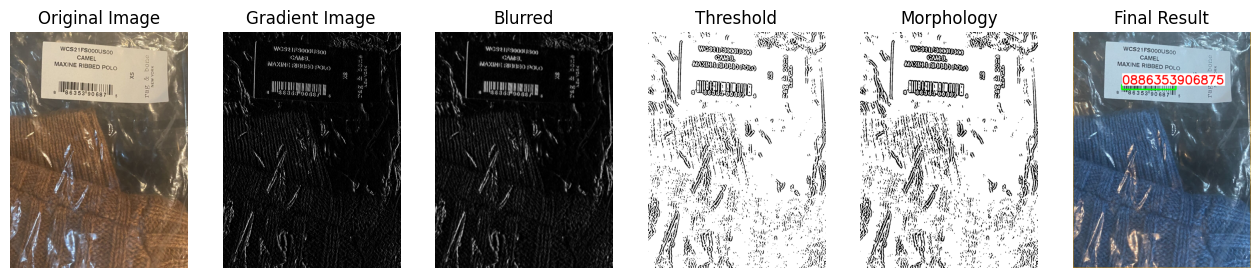

Analyzing Image
Decoded Barcode: 6221004503364
Decoded Barcodes: ['6221004503364']


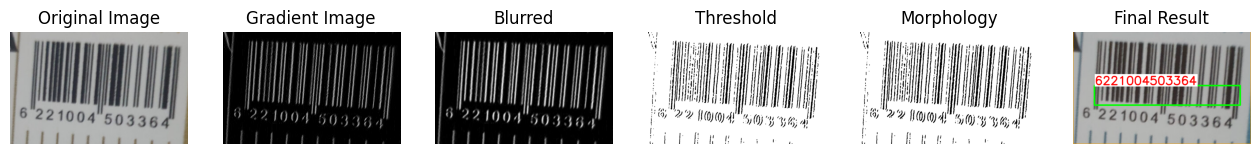

Analyzing Image
Decoded Barcode: 21123456789
Decoded Barcodes: ['21123456789']


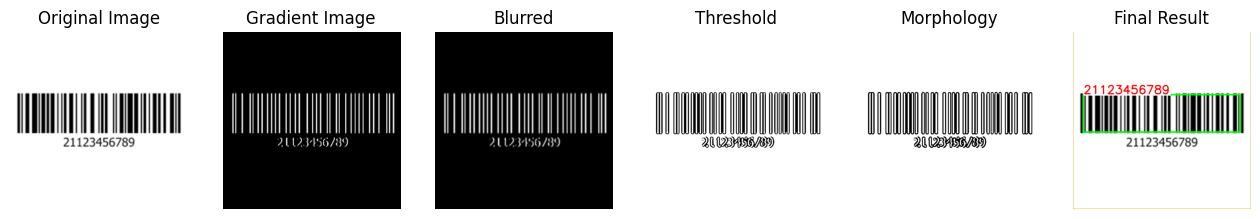

Analyzing Image
Decoded Barcode: 9336672318343
Decoded Barcodes: ['9336672318343']


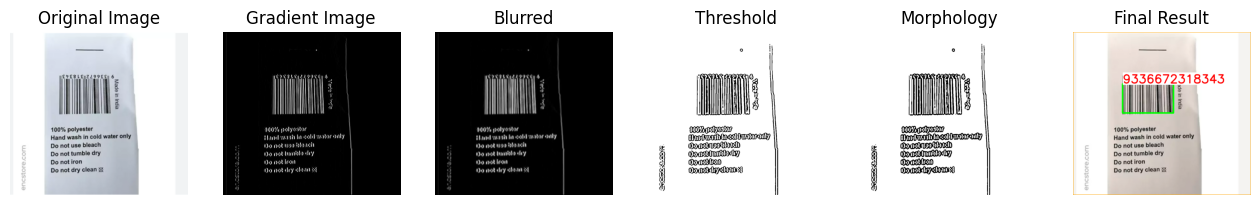

Analyzing Image
Decoded Barcode: 8907587024684
Decoded Barcodes: ['8907587024684']


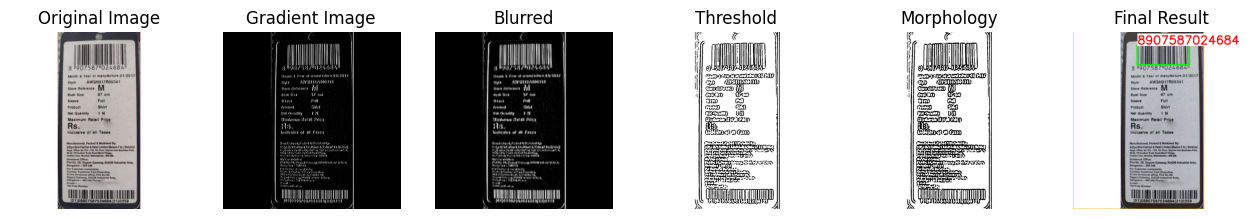

Analyzing Image
Decoded Barcode: 00443548
Decoded Barcode: 05821444
Decoded Barcode: 00400439
Decoded Barcodes: ['00443548', '05821444', '00400439']


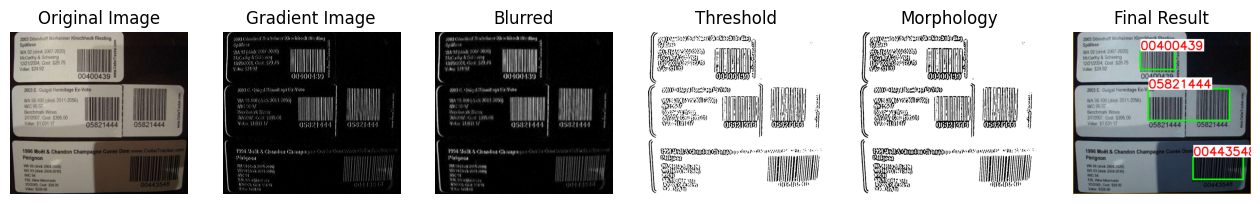

Analyzing Image
Decoded Barcode: 00395011015300000011403402621
Decoded Barcode: 401950110153B01001
Decoded Barcodes: ['00395011015300000011403402621', '401950110153B01001']


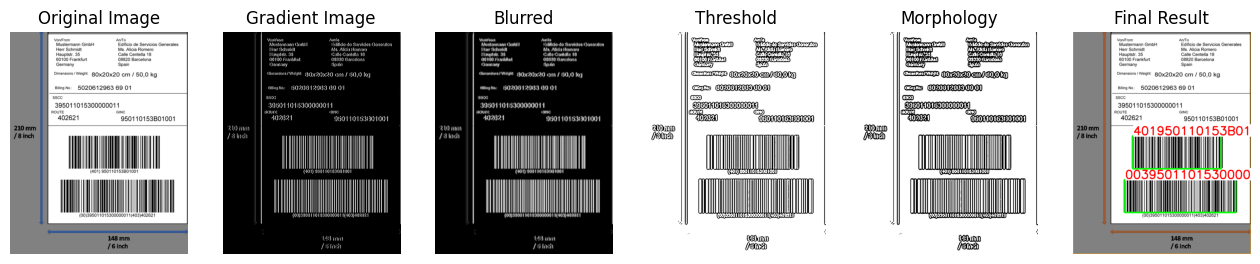

Analyzing Image
Decoded Barcode: 910277
Decoded Barcode: 910279
Decoded Barcode: 910585
Decoded Barcode: 910323
Decoded Barcode: 910262
Decoded Barcode: 910508
Decoded Barcode: 910519
Decoded Barcode: 910256
Decoded Barcodes: ['910277', '910279', '910585', '910323', '910262', '910508', '910519', '910256']


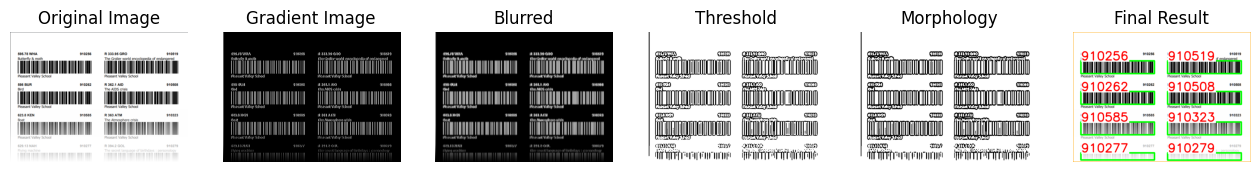

Analyzing Image
Decoded Barcode: 2125402300043
Decoded Barcode: 2125402300042
Decoded Barcodes: ['2125402300043', '2125402300042']


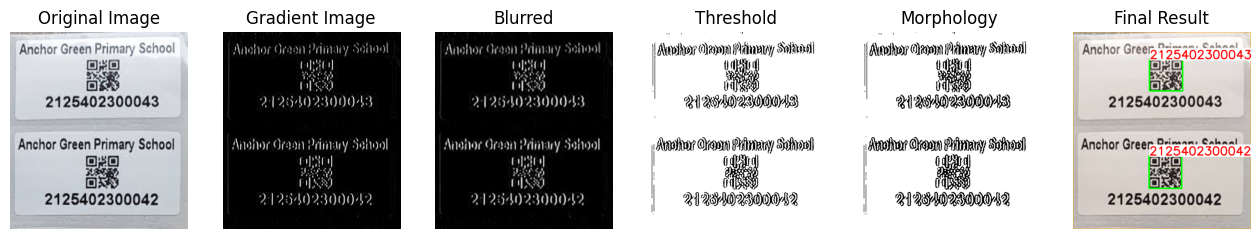

Analyzing Image
Decoded Barcode: 1Z560E396899137463
Decoded Barcode: 42125069500
Decoded Barcodes: ['1Z560E396899137463', '42125069500']


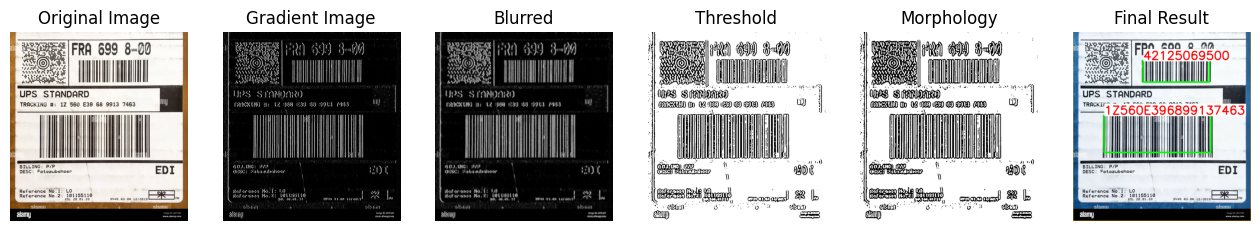

Analyzing Image
Decoded Barcode: 1ZE5991R6800262475
Decoded Barcode: 421826NG85NL
Decoded Barcodes: ['1ZE5991R6800262475', '421826NG85NL']


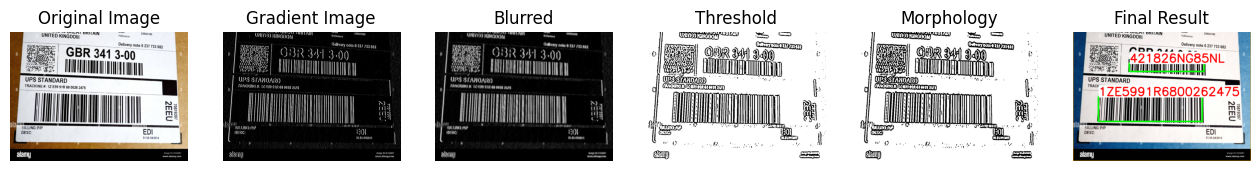

Analyzing Image
Decoded Barcode: 420075129274890990075822242836
Decoded Barcodes: ['42007512\x1d9274890990075822242836']


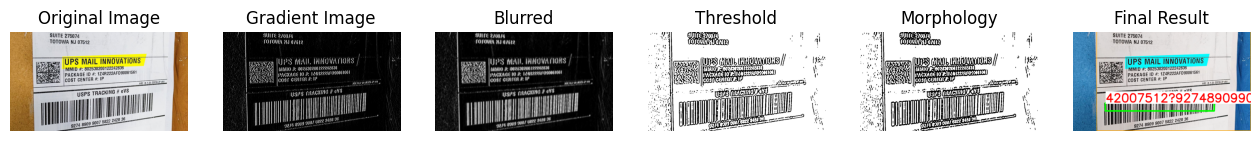

Analyzing Image
Decoded Barcode: 9783981305449
Decoded Barcodes: ['9783981305449']


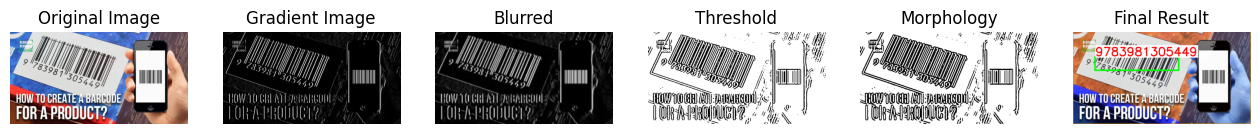

Analyzing Image
Decoded Barcode: 9780201379624
Decoded Barcodes: ['9780201379624']


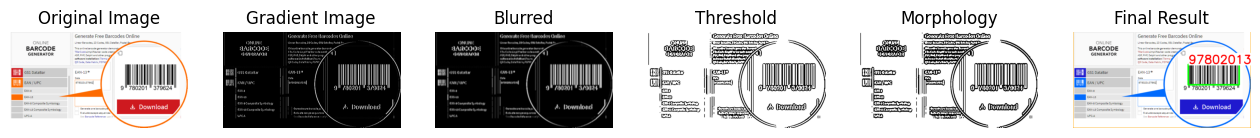

Analyzing Image
Decoded Barcode: https://www.fbbonline.in/scan/1001656712
Decoded Barcode: 8905011502814
Decoded Barcodes: ['https://www.fbbonline.in/scan/1001656712', '8905011502814']


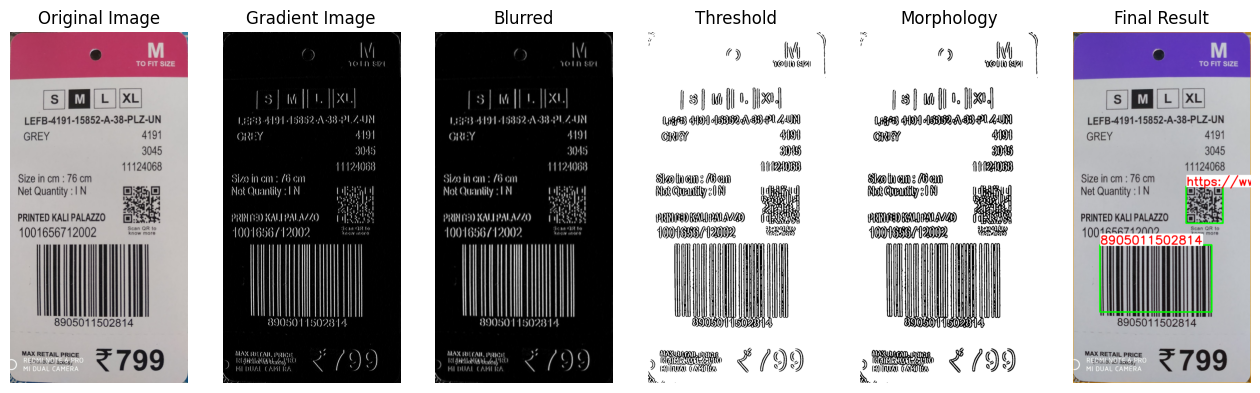

Analyzing Image
Decoded Barcode: 00101231300002372931
Decoded Barcode: 91099481
Decoded Barcode: 42016172
Decoded Barcodes: ['00101231300002372931', '91099481', '42016172']


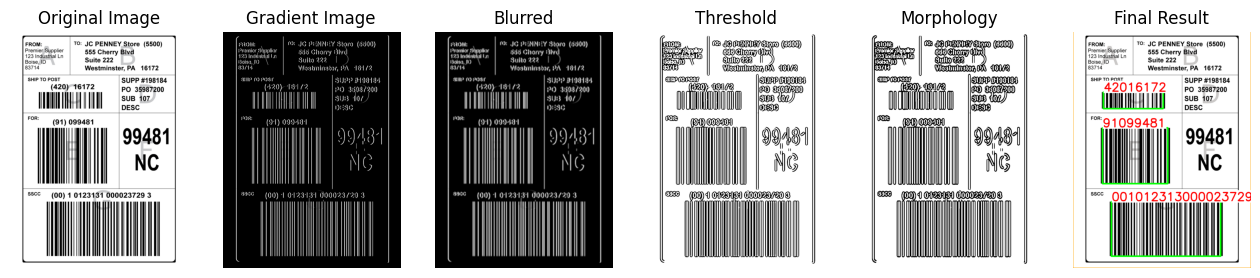

Analyzing Image
Decoded Barcode: 012739437661622215240212103043AAG
Decoded Barcodes: ['012739437661622215240212103043AAG']


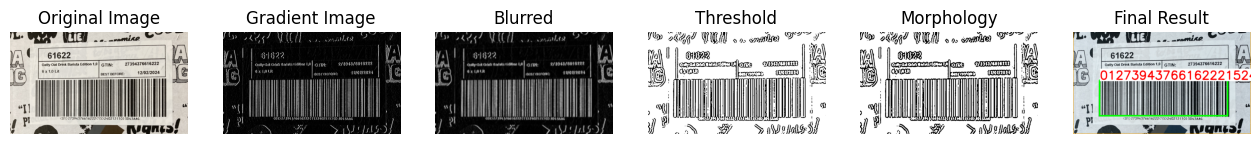

Analyzing Image
Decoded Barcode: http://www.zara.com/qr/1321191004041
Decoded Barcode: 13211910040411
Decoded Barcodes: ['http://www.zara.com/qr/1321191004041', '13211910040411']


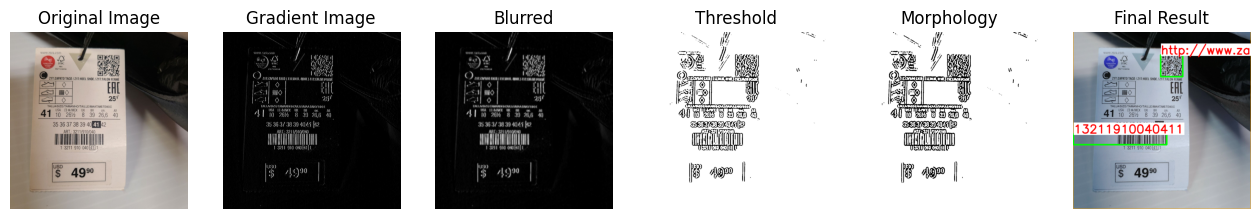

Analyzing Image
Decoded Barcode: 00006141411234567890
Decoded Barcode: 020061414100041815210228104512143720
Decoded Barcodes: ['00006141411234567890', '02006141410004181521022810451214\x1d3720']


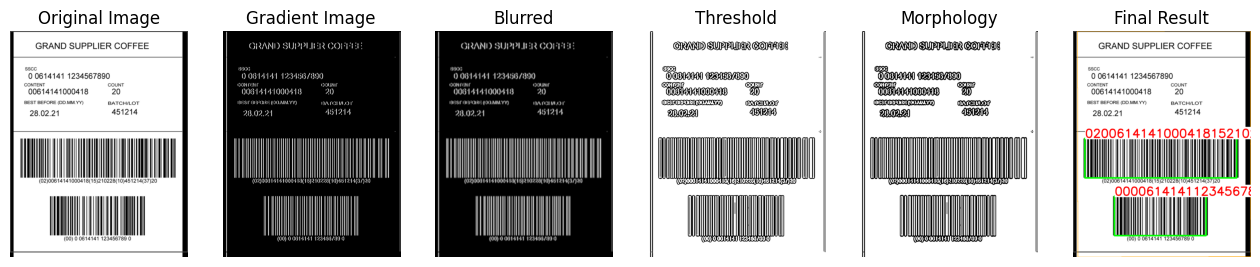

Analyzing Image
Decoded Barcode: 4S12345678
Decoded Barcode: KXXXXXXX
Decoded Barcode: P12345678
Decoded Barcode: Q654321
Decoded Barcodes: ['4S12345678', 'KXXXXXXX', 'P12345678', 'Q654321']


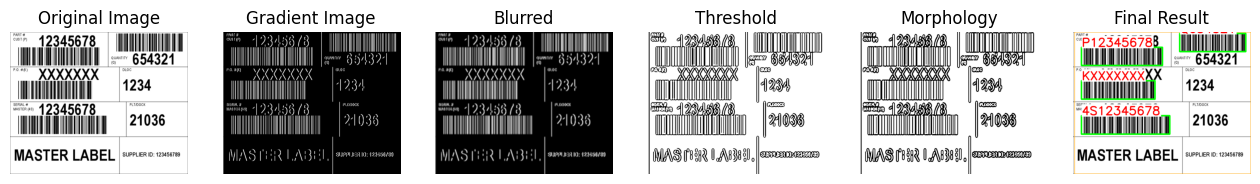

Analyzing Image
Decoded Barcode: 00001234560000000018
Decoded Barcode: 910844
Decoded Barcode: 42075236
Decoded Barcodes: ['00001234560000000018', '910844', '42075236']


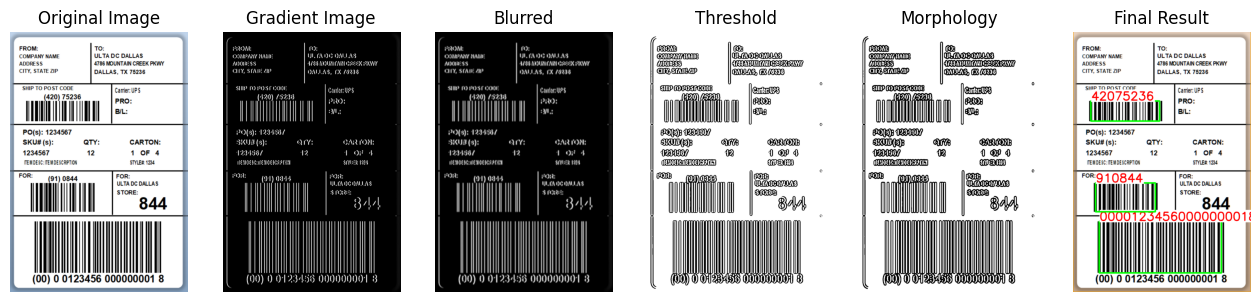

Analyzing Image
Decoded Barcode: 0123456789005
Decoded Barcodes: ['0123456789005']


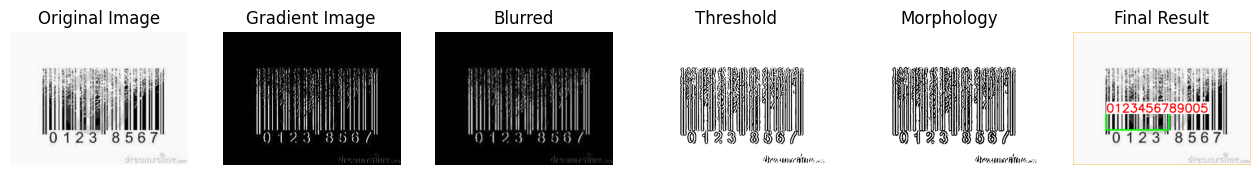

Analyzing Image
No barcodes found.
No barcodes detected.


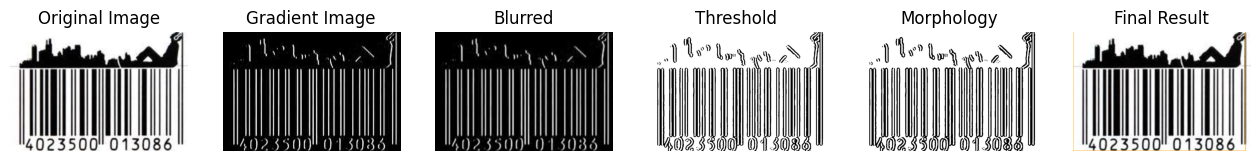

Analyzing Image
Decoded Barcode: 9780201379624
Decoded Barcodes: ['9780201379624']


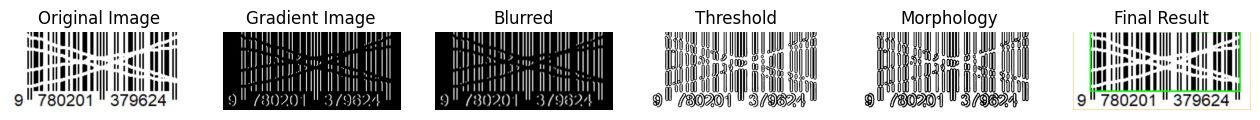

Analyzing Image
Decoded Barcode: 0558242663359
Decoded Barcodes: ['0558242663359']


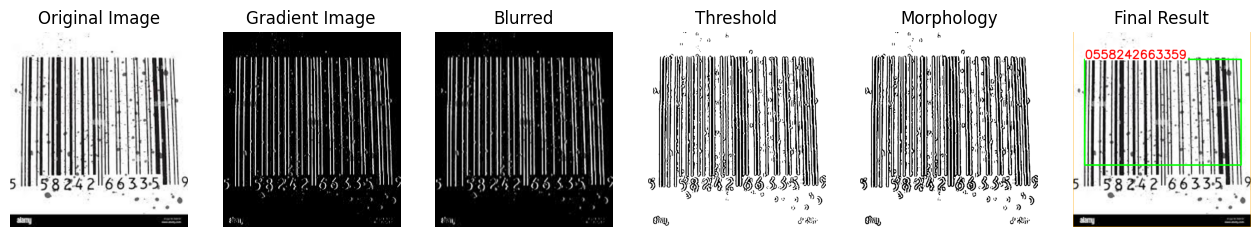

Analyzing Image
Decoded Barcode: http://DataGenetics.com
Decoded Barcodes: ['http://DataGenetics.com']


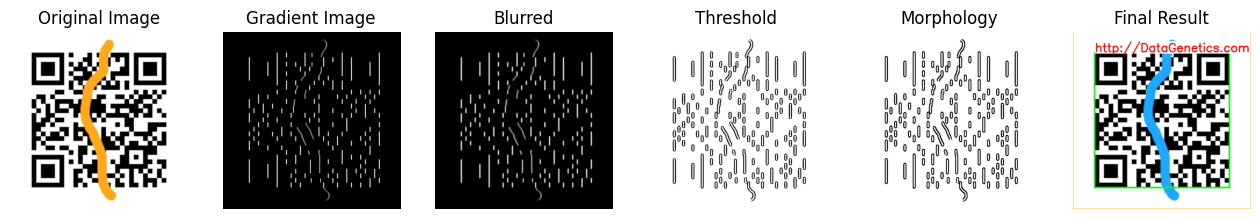

Analyzing Image
Decoded Barcode: 8717163019535
Decoded Barcodes: ['8717163019535']


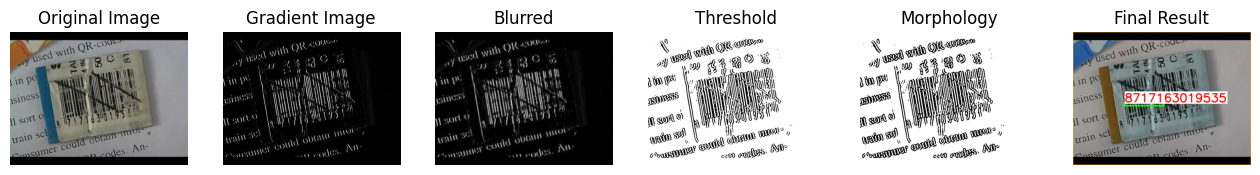

Analyzing Image
Decoded Barcode: 8004537608212
Decoded Barcodes: ['8004537608212']


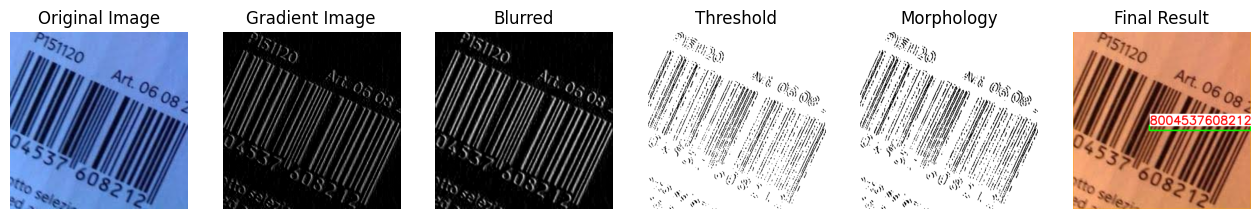

Analyzing Image
Decoded Barcode: 4004135608212
Decoded Barcode: 8004537608212
Decoded Barcodes: ['4004135608212', '8004537608212']


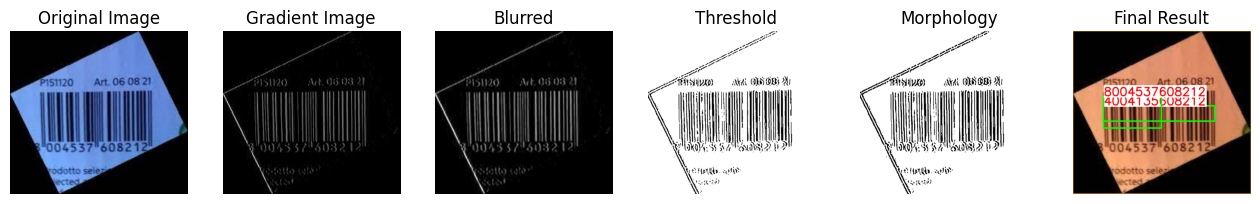

Analyzing Image
Decoded Barcode: http://en.m.wikipedia.org
Decoded Barcodes: ['http://en.m.wikipedia.org']


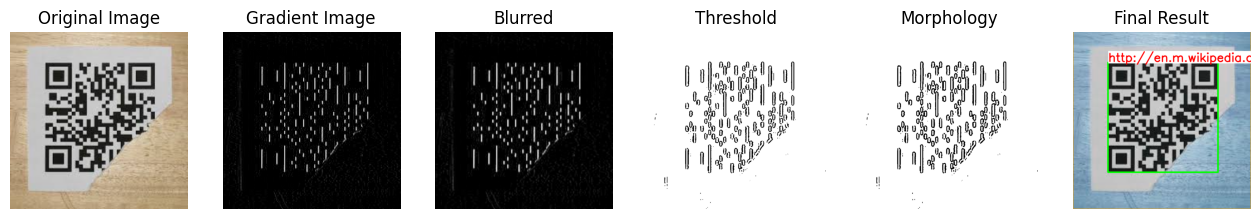

Analyzing Image
Decoded Barcode: 2051M

Decoded Barcodes: ['2051M\n']


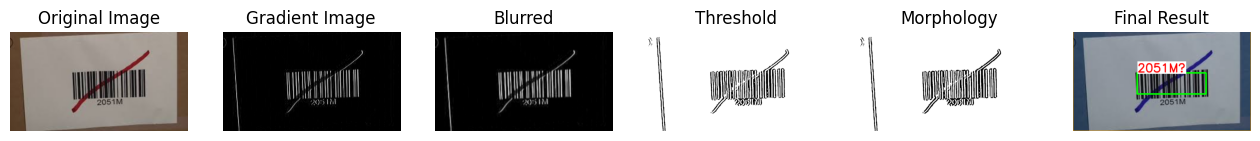

In [ ]:
image_folder = "/content/drive/MyDrive/DIP_FinalProject/input_image/*"
for image_path in glob.glob(image_folder):
    try:
        print(f"Analyzing Image")
        analyze_image(image_path)
    except Exception as e:
        print(f"Error processing {image_path}: {e}")